# EOSC 582 Final Project (Sea-ice classification)

In [3]:
__author__ = 'Yingkai (Kyle) Sha'
__email__  = 'yingkai@eos.ubc.ca'

In [4]:
#from IPython.core.display import HTML
#HTML(open("../custom.css", "r").read());

# Content
1. [**Shared functions**](#Shared-functions)
1. [**Read data**](#Read-data)
1. [**Sea-ice classification**](#Sea-ice-classification)
  2. [Grenfell, T. C. & D. L. Bell, 1989](#Grenfell,-T.-C.-&-D.-L.-Bell,-1989)
  2. [Cavalieri et al., 1986](#Cavalieri-et-al.,-1986)
  2. [Cavalieri, 1988](#Cavalieri,-1988)

In [5]:
import glob
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
% matplotlib inline

In [6]:
from sklearn.cluster import KMeans # KMeans
#from sklearn.metrics.pairwise import pairwise_distances_argmin
#from sklearn.mixture import GMM # Gaussian mixture
#from matplotlib.colors import LogNorm

In [7]:
import warnings
warnings.filterwarnings('ignore')

# Shared functions

In [8]:
def find_inland(lon, lat):
    '''
    Identify if data points are located in land
    Based on Basemap's GSHHS dataset
    '''
    from matplotlib.path import Path
    result = np.empty(lon.shape)
    proj = Basemap(projection='cyl', resolution='l')
    for i in range(np.size(lon, 0)):
        x, y = proj(lon[i, :], lat[i, :])
        locations = np.c_[x, y]
        polygons = [Path(p.boundary) for p in proj.landpolygons]
        row_result = np.zeros(len(locations), dtype=bool) 
        for polygon in polygons:
            row_result += np.array(polygon.contains_points(locations))
        result[i, :] = row_result
    return result

In [9]:
def planck(frequency, temperature):
    return 4.6323506e-50 * frequency**3 / (np.exp(4.79927e-11 * frequency/temperature)-1);
def po_ratio(vpol, hpol):
    return (vpol-hpol)/(vpol+hpol)
def grad_ratio(vpol1, vpol2):
    return (vpol2-vpol1)/(vpol2+vpol1)

In [10]:
def map_Arctic(ax):
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=90, round=True, ax=ax)
    # parallels & meridians
    parallels=np.arange(-90, 90, 15); meridians=np.arange(0, 360, 60)
    proj.drawparallels(parallels, labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
    proj.drawmeridians(meridians, labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
    # coastline, maskland
    proj.drawcoastlines(linewidth=1.5, linestyle='-', color='k', zorder=3)
    #proj.drawlsmask(land_color=[0.5, 0.5, 0.5], ocean_color='None', lsmask=None, zorder=2)
    return proj 

In [11]:
def hist2dxy(hist_x, hist_y, Xnum, Ynum, clevs, CMap=plt.cm.gist_ncar_r):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    Xlim=[np.nanmin(hist_x), np.nanmax(hist_x)]
    Xbins=np.linspace(Xlim[0], Xlim[1], Xnum, dtype=np.float)
    Ylim=[np.nanmin(hist_y), np.nanmax(hist_y)]
    Ybins=np.linspace(Ylim[0], Ylim[1], Ynum, dtype=np.float)
    H, y_edges, x_edges = np.histogram2d(hist_y, hist_x, bins=(Ybins, Xbins))
    X, Y = np.meshgrid(x_edges[:-1], y_edges[:-1])
    # set axis
    left=0.1; width = 0.8; bottom=0.1; height = 0.65
    gap=0.02; hist_len=0.2; cbar_len=0.12
    # three boxes
    rect_main  = [left+hist_len+gap, bottom, width, height]
    rect_histx = [left+hist_len+gap, left+height+gap, width-cbar_len, hist_len]
    rect_histy = [left, bottom, hist_len, height]
    # x, y limits
    xlim_bin=[np.min(X), np.max(X)]
    ylim_bin=[np.min(Y), np.max(Y)]
    # ========== figure ========== #
    fig=plt.figure(figsize=(9, 9))
    # ========== Main ========== #
    # axis
    axMain=plt.axes(rect_main)
    axMain.yaxis.tick_right()
    axMain.yaxis.set_label_position('right')
    axMain.set_xlim(xlim_bin)
    axMain.set_ylim(ylim_bin)
    divider=make_axes_locatable(axMain)
    # grid and frame
    axMain.grid() # grid on
    [i.set_linewidth(2) for i in axMain.spines.itervalues()] # a bold frame
    CS=axMain.contourf(X, Y, H, clevs, cmap=CMap, extend='max') # 2-D histgram
    CAx=divider.append_axes('right', size='5%', pad=0.75)
    CBar=plt.colorbar(CS, cax=CAx)
    CBar.set_label('Number of points', fontsize=10)
    CBar.ax.tick_params(axis='y', length=22.5)
    # ========== Hist-x ========== #
    axHistx=plt.axes(rect_histx)
    axHistx.hist(hist_x, bins=Xbins, color='gray')
    axHistx.set_xlim(Xlim)
    axHistx.axes.get_xaxis().set_visible(False)
    # scientific notation for x, y-axis
    plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    [i.set_linewidth(2) for i in axHistx.spines.itervalues()]
    axHistx.grid()
    # ========== Hist-y ========== #
    axHisty = plt.axes(rect_histy)
    axHisty.hist(hist_y, bins=Ybins, color='gray', orientation='horizontal')
    axHisty.set_ylim(Ylim)
    axHisty.invert_xaxis()
    axHisty.axes.get_yaxis().set_visible(False)
    plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    [i.set_linewidth(2) for i in axHisty.spines.itervalues()]
    axHisty.grid()
    return axMain, axHistx, axHisty

In [12]:
def kmean_sort(k_means):
    centers = k_means.cluster_centers_[:, 1]
    return np.argsort(centers)
def kmean_fig(k_means, TrainData, ax, colors, names):
    order = kmean_sort(k_means)
    k_means_labels = k_means.labels_
    k_means_cluster_centers = k_means.cluster_centers_[order, :]
    #k_means_labels_unique = np.unique(k_means_labels)
    for k, col in zip(range(n_clusters), colors):
        my_members = k_means_labels == order[k]
        cluster_center = k_means_cluster_centers[k]
        ax.plot(TrainData[my_members, 0], TrainData[my_members, 1], 'w.', mfc=col)
        ax.plot(cluster_center[0], cluster_center[1], 'o', mfc=col, mec='k', markersize=12, label=names[k])

In [13]:
def back_indexing(k_means, hit, n_clusters, ori_size=[721, 721]):
    types = np.zeros(ori_size[0]*ori_size[1]); types[types==0]=np.nan
    labels = k_means.labels_.astype(float)
    count=0;
    for i in range(len(hit)):
        if hit[i]:
            types[i]=labels[count]
            count+=1
    ICE_Type = np.reshape(types, ori_size)
    # re-order
    order = kmean_sort(k_means)
    temp = np.copy(ICE_Type)
    for i in range(n_clusters):
        ICE_Type[temp==order[i]]=i
    return ICE_Type

In [14]:
def plot_icetypes(ICE_Type_m, ax, n_clusters, names, CMap):
    proj = map_Arctic(ax)
    x, y = proj(lon_m, lat_m)
    CS = plt.contourf(x, y, ICE_Type_m, n_clusters, cmap=CMap)
    #proj.pcolor(x, y, ICE_Type_m, cmap=CMap)
    proxy = [plt.Rectangle((0, 0), 1, 1, fc = pc.get_facecolor()[0]) for pc in CS.collections]
    ax.legend(proxy, names, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=1)
    return proj

In [15]:
# nonlinear colormap, borrowed from Robert Hetland <hetland@tamu.edu>, under MIT license.
# http://protracted-matter.blogspot.ca/2012/08/nonlinear-colormap-in-matplotlib.html
from matplotlib.colors import LinearSegmentedColormap
class nlcmap(LinearSegmentedColormap):
    name = 'nlcmap'    
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels / self.levels.max()
        self._y = np.linspace(0.0, 1.0, len(self.levels))
    def __call__(self, xi, alpha=1.0, **kw):
        """docstring for fname"""
        yi = np.interp(xi, self._x, self._y)
        return self.cmap(yi, alpha)

# Read data

In [16]:
nc_Feb = nc.Dataset('_data/NSIDC-0342_85657.nc')
namelist = nc_Feb.variables.keys() 

In [17]:
gap = 1
lat = nc_Feb.variables['latitude'][::gap, ::gap]
lon = nc_Feb.variables['longitude'][::gap, ::gap]

In [18]:
# Ascending
TB19V_A = nc_Feb.variables[ namelist[9]][0, ::gap, ::gap].astype(float)/10
TB19H_A = nc_Feb.variables[namelist[16]][0, ::gap, ::gap].astype(float)/10
TB22V_A = nc_Feb.variables[namelist[11]][0, ::gap, ::gap].astype(float)/10
TB37V_A = nc_Feb.variables[ namelist[4]][0, ::gap, ::gap].astype(float)/10
TB37H_A = nc_Feb.variables[ namelist[5]][0, ::gap, ::gap].astype(float)/10
TB91V_A = nc_Feb.variables[namelist[14]][0, ::gap, ::gap].astype(float)/10
TB91H_A = nc_Feb.variables[namelist[15]][0, ::gap, ::gap].astype(float)/10
# Descending
TB19V_D = nc_Feb.variables[ namelist[8]][0, ::gap, ::gap].astype(float)/10
TB19H_D = nc_Feb.variables[ namelist[7]][0, ::gap, ::gap].astype(float)/10
TB22V_D = nc_Feb.variables[ namelist[6]][0, ::gap, ::gap].astype(float)/10
TB37V_D = nc_Feb.variables[namelist[17]][0, ::gap, ::gap].astype(float)/10
TB37H_D = nc_Feb.variables[namelist[10]][0, ::gap, ::gap].astype(float)/10
TB91V_D = nc_Feb.variables[namelist[13]][0, ::gap, ::gap].astype(float)/10
TB91H_D = nc_Feb.variables[namelist[12]][0, ::gap, ::gap].astype(float)/10

## Delete inland grids

In [19]:
hit = find_inland(lon, lat)
bound_lat = 66

In [20]:
TB19V_A[hit==1]=np.nan; TB19V_A[TB19V_A<100]=np.nan; TB19V_A[lat<bound_lat]=np.nan
TB19H_A[hit==1]=np.nan; TB19H_A[TB19H_A<100]=np.nan; TB19H_A[lat<bound_lat]=np.nan
TB37V_A[hit==1]=np.nan; TB37V_A[TB37V_A<100]=np.nan; TB37V_A[lat<bound_lat]=np.nan
TB37H_A[hit==1]=np.nan; TB37H_A[TB37H_A<100]=np.nan; TB37H_A[lat<bound_lat]=np.nan
TB91V_A[hit==1]=np.nan; TB91V_A[TB91V_A<100]=np.nan; TB91V_A[lat<bound_lat]=np.nan
TB91H_A[hit==1]=np.nan; TB91H_A[TB91H_A<100]=np.nan; TB91H_A[lat<bound_lat]=np.nan

TB19V_m=np.ma.masked_where(np.isnan(TB19V_A), TB19V_A)
TB19H_m=np.ma.masked_where(np.isnan(TB19H_A), TB19H_A)
TB37V_m=np.ma.masked_where(np.isnan(TB37V_A), TB37V_A)
TB37H_m=np.ma.masked_where(np.isnan(TB37H_A), TB37H_A)
TB91V_m=np.ma.masked_where(np.isnan(TB91V_A), TB91V_A)
TB91H_m=np.ma.masked_where(np.isnan(TB91H_A), TB91H_A)

lon[lat<bound_lat]=np.nan; lon_m = np.ma.masked_where(np.isnan(lon), lon)
lat[lat<bound_lat]=np.nan; lat_m = np.ma.masked_where(np.isnan(lat), lat)

## Plot input data

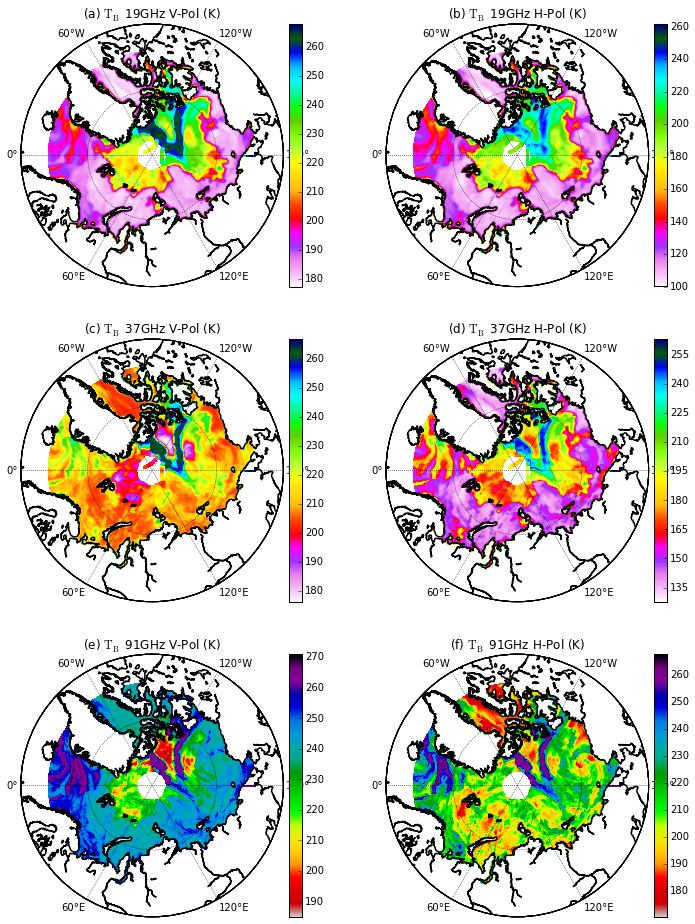

In [21]:
fig = plt.figure(figsize=(12, 16))
ax1=plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=1); ax2=plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1)
ax3=plt.subplot2grid((3, 2), (1, 0), colspan=1, rowspan=1); ax4=plt.subplot2grid((3, 2), (1, 1), colspan=1, rowspan=1)
ax5=plt.subplot2grid((3, 2), (2, 0), colspan=1, rowspan=1); ax6=plt.subplot2grid((3, 2), (2, 1), colspan=1, rowspan=1)

proj1 = map_Arctic(ax1); proj2 = map_Arctic(ax2); proj3 = map_Arctic(ax3)
proj4 = map_Arctic(ax4); proj5 = map_Arctic(ax5); proj6 = map_Arctic(ax6)
x, y = proj1(lon_m, lat_m)

CS = proj1.pcolor(x, y, TB19V_m, cmap=plt.cm.gist_ncar_r); proj1.colorbar(CS)
ax1.set_title('(a) $\mathrm{T_B}$ 19GHz V-Pol (K)', fontsize=12)
CS = proj2.pcolor(x, y, TB19H_m, cmap=plt.cm.gist_ncar_r); proj2.colorbar(CS)
ax2.set_title('(b) $\mathrm{T_B}$ 19GHz H-Pol (K)', fontsize=12)
CS = proj3.pcolor(x, y, TB37V_m, cmap=plt.cm.gist_ncar_r); proj3.colorbar(CS)
ax3.set_title('(c) $\mathrm{T_B}$ 37GHz V-Pol (K)', fontsize=12)
CS = proj4.pcolor(x, y, TB37H_m, cmap=plt.cm.gist_ncar_r); proj4.colorbar(CS)
ax4.set_title('(d) $\mathrm{T_B}$ 37GHz H-Pol (K)', fontsize=12)
CS = proj5.pcolor(x, y, TB91V_m, cmap=plt.cm.nipy_spectral_r); proj5.colorbar(CS)
ax5.set_title('(e) $\mathrm{T_B}$ 91GHz V-Pol (K)', fontsize=12)
CS = proj6.pcolor(x, y, TB91H_m, cmap=plt.cm.nipy_spectral_r); proj6.colorbar(CS)
ax6.set_title('(f) $\mathrm{T_B}$ 91GHz H-Pol (K)', fontsize=12)

# Sea-ice classification

In [22]:
Xnum = 150;  Ynum = 150
vpol_37 = TB37V_A.flatten().astype(np.float); 
vpol_19 = TB19V_A.flatten().astype(np.float);
hpol_37 = TB37H_A.flatten().astype(np.float);
hpol_19 = TB19H_A.flatten().astype(np.float);
vpol_91 = TB91V_A.flatten().astype(np.float);
# map, contour levs
clevs=[1, 5, 10, 15, 20, 25, 30, 35, 50]
CMap = nlcmap(plt.cm.nipy_spectral_r, clevs)

## Grenfell, T. C. & D. L. Bell, 1989

### Histogram

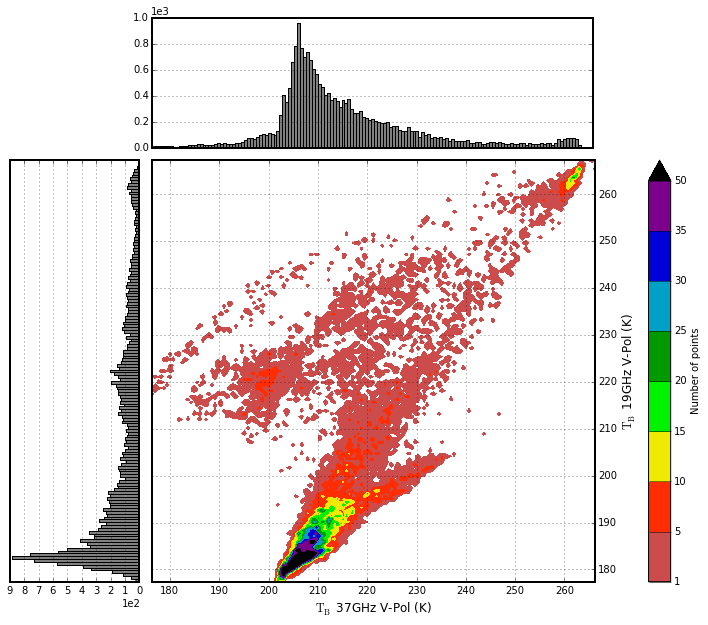

In [23]:
axMain, axHistx, axHisty = hist2dxy(vpol_37, vpol_19, Xnum, Ynum, clevs, CMap=CMap)
axMain.set_xlabel('$\mathrm{T_B}$ 37GHz V-Pol (K)', fontsize=12)
axMain.set_ylabel('$\mathrm{T_B}$ 19GHz V-Pol (K)', fontsize=12)

### K-means clustering

In [24]:
n_clusters = 5
TrainData = np.column_stack((vpol_37, vpol_19))
hit = ~(np.isnan(TrainData[:, 0]) | np.isnan(TrainData[:, 1]))
TrainData = TrainData[hit]

In [25]:
k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
k_means.fit(TrainData)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

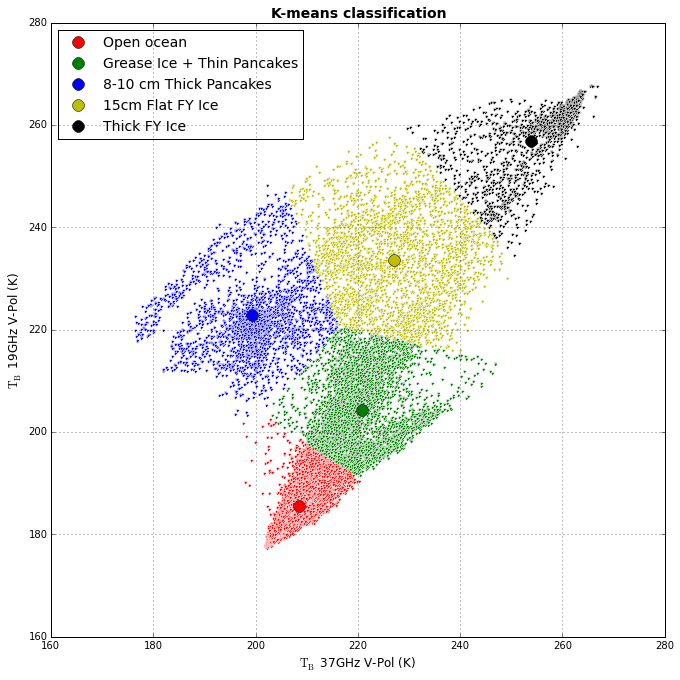

In [26]:
colors = ['r', 'g', 'b', 'y', 'k']
names = ['Open ocean', 'Grease Ice + Thin Pancakes', '8-10 cm Thick Pancakes', '15cm Flat FY Ice', 'Thick FY Ice']
fig = plt.figure(figsize=(11, 11))
ax = fig.gca(); kmean_fig(k_means, TrainData, ax, colors, names)
ax.grid(); ax.set_title('K-means classification', fontweight='bold', fontsize=14)
ax.legend(numpoints=1, fontsize=14, loc=2)
ax.set_xlabel('$\mathrm{T_B}$ 37GHz V-Pol (K)', fontsize=12)
ax.set_ylabel('$\mathrm{T_B}$ 19GHz V-Pol (K)', fontsize=12)

### Plot the classification

In [27]:
ICE_Type = back_indexing(k_means, hit, n_clusters)
#ICE_Type_m = np.ma.masked_where(np.isnan(TB19V_A), ICE_Type)

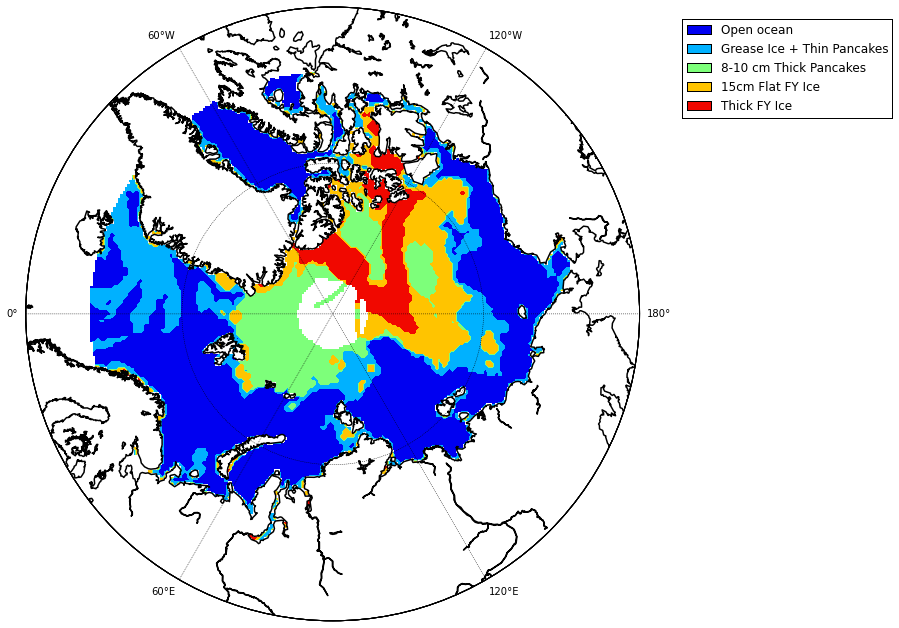

In [28]:
fig = plt.figure(figsize=(11, 11))
ax = fig.gca(); CMap=plt.cm.jet
plot_icetypes(ICE_Type, ax, n_clusters, names, CMap)

## Cavalieri et al., 1986

In [29]:
clevs=[1, 5, 10, 15, 20, 25, 30, 35, 50]
CMap = nlcmap(plt.cm.nipy_spectral_r, clevs)

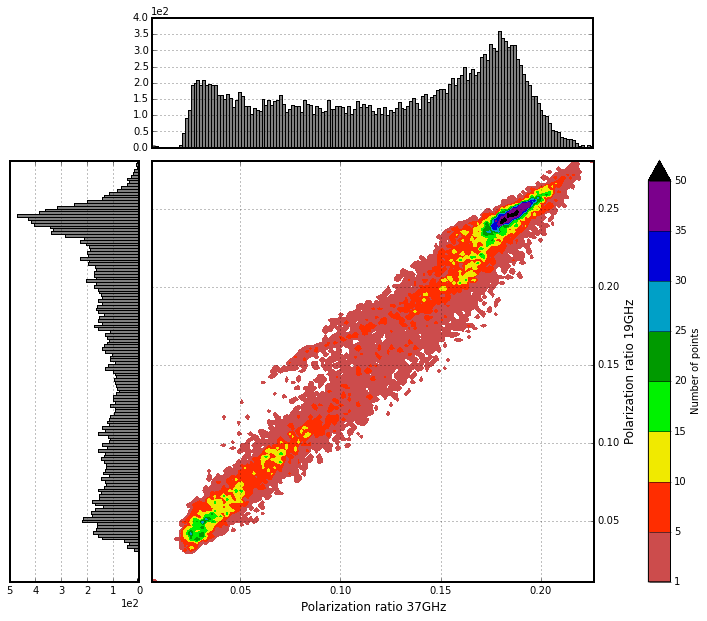

In [30]:
PR37 = po_ratio(vpol_37, hpol_37)
PR19 = po_ratio(vpol_19, hpol_19)
axMain, axHistx, axHisty = hist2dxy(PR37, PR19, Xnum, Ynum, clevs, CMap=CMap)
axMain.set_xlabel('Polarization ratio 37GHz', fontsize=12)
axMain.set_ylabel('Polarization ratio 19GHz', fontsize=12)

### K-means clustering

In [31]:
n_clusters = 5
TrainData = np.column_stack((PR37, PR19))
hit = ~(np.isnan(TrainData[:, 0]) | np.isnan(TrainData[:, 1]))
TrainData = TrainData[hit]

In [32]:
k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
k_means.fit(TrainData)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

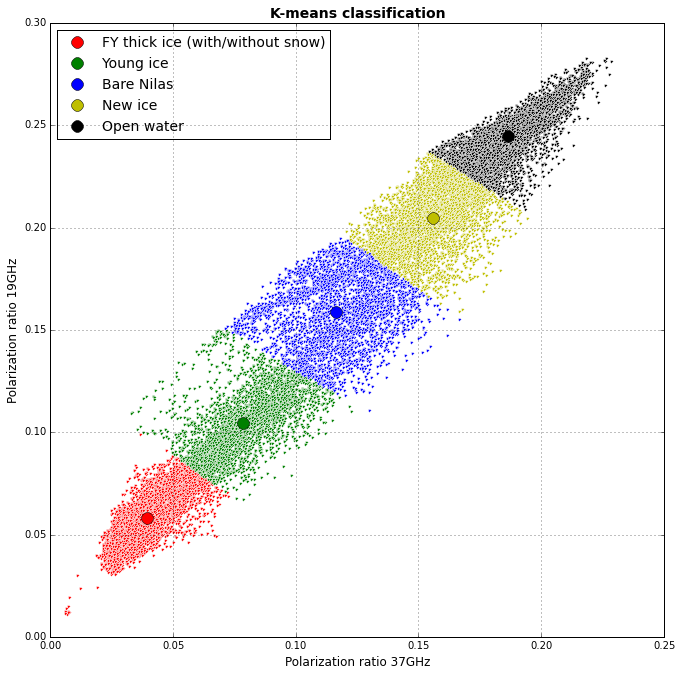

In [33]:
colors = ['r', 'g', 'b', 'y', 'k']
names = ['FY thick ice (with/without snow)', 'Young ice', 'Bare Nilas', 'New ice', 'Open water']
fig = plt.figure(figsize=(11, 11))
ax = fig.gca(); kmean_fig(k_means, TrainData, ax, colors, names)
ax.grid(); ax.set_title('K-means classification', fontweight='bold', fontsize=14)
ax.legend(numpoints=1, fontsize=14, loc=2)
ax.set_xlabel('Polarization ratio 37GHz', fontsize=12)
ax.set_ylabel('Polarization ratio 19GHz', fontsize=12)

In [34]:
ICE_Type = back_indexing(k_means, hit, n_clusters)

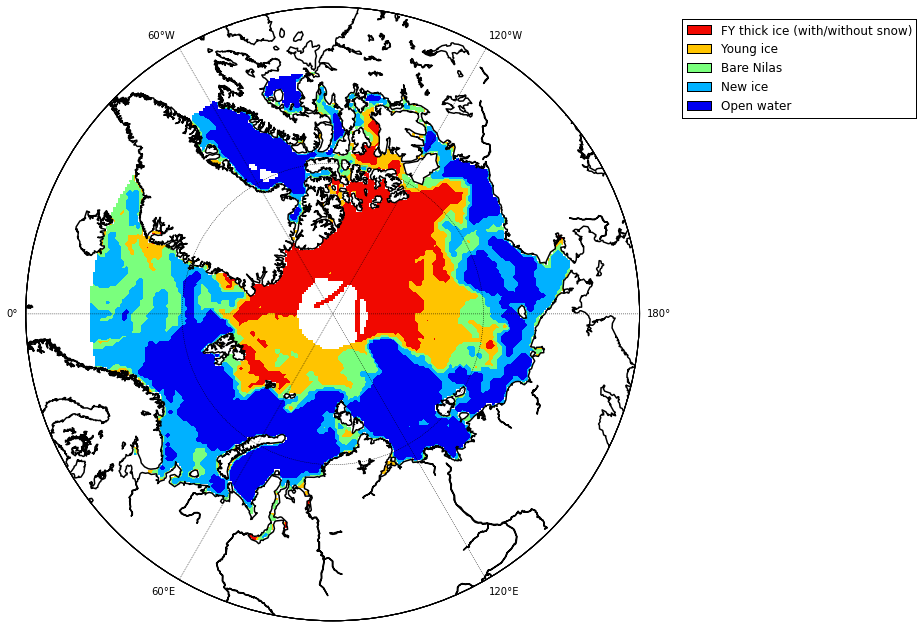

In [35]:
fig = plt.figure(figsize=(11, 11))
ax = fig.gca(); CMap=plt.cm.jet_r
plot_icetypes(ICE_Type, ax, n_clusters, names, CMap)

## Cavalieri, 1988

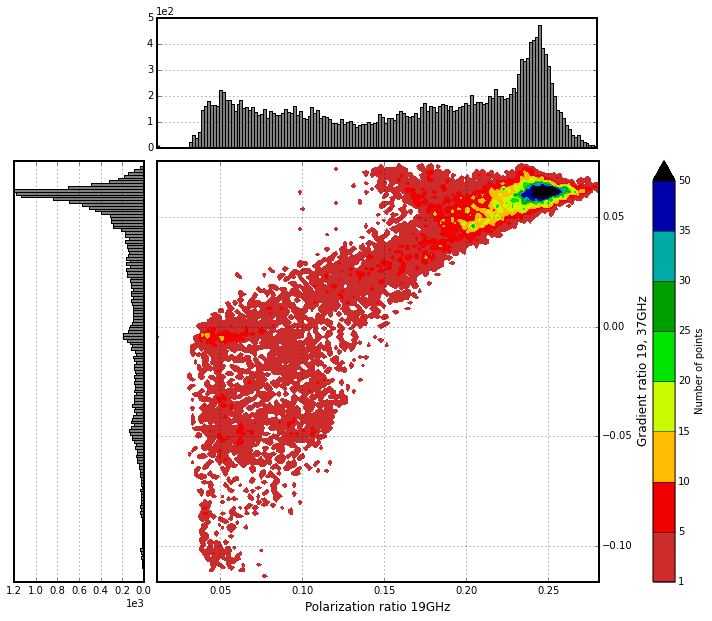

In [36]:
GR1937 = grad_ratio(vpol_19, vpol_37)
axMain, axHistx, axHisty = hist2dxy(PR19, GR1937, Xnum, Ynum, clevs, CMap=plt.cm.nipy_spectral_r)
axMain.set_xlabel('Polarization ratio 19GHz', fontsize=12)
axMain.set_ylabel('Gradient ratio 19, 37GHz', fontsize=12)

### K-means clustering

In [37]:
n_clusters = 3
TrainData = np.column_stack((PR19, GR1937))
TrainData = TrainData[~(np.isnan(TrainData[:, 0]) | np.isnan(TrainData[:, 1]))]

In [38]:
k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
k_means.fit(TrainData)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

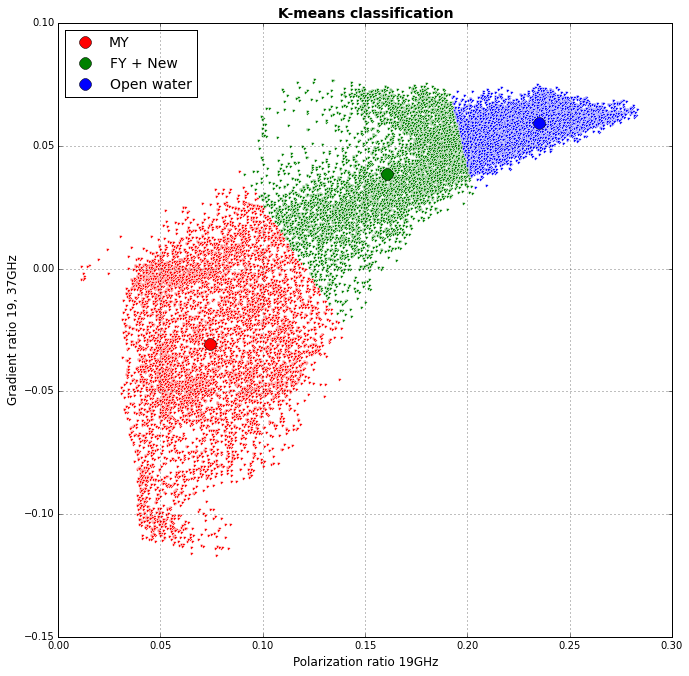

In [39]:
colors = ['r', 'g', 'b']
names = ['MY', 'FY + New ', 'Open water']
fig = plt.figure(figsize=(11, 11))
ax = fig.gca(); kmean_fig(k_means, TrainData, ax, colors, names)
ax.grid(); ax.set_title('K-means classification', fontweight='bold', fontsize=14)
ax.legend(numpoints=1, fontsize=14, loc=2)
ax.set_xlabel('Polarization ratio 19GHz', fontsize=12)
ax.set_ylabel('Gradient ratio 19, 37GHz', fontsize=12)

In [40]:
ICE_Type = back_indexing(k_means, hit, n_clusters)

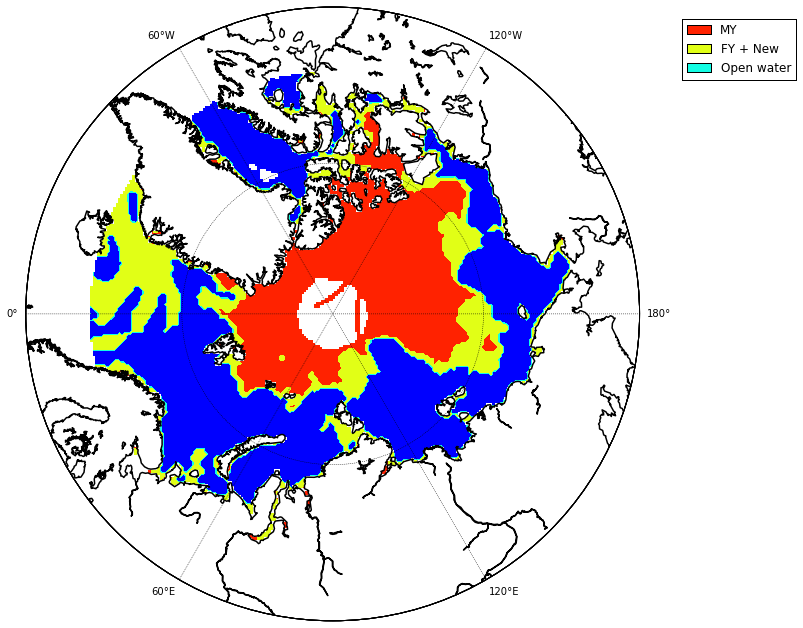

In [41]:
fig = plt.figure(figsize=(11, 11))
ax = fig.gca(); CMap=plt.cm.jet_r
plot_icetypes(ICE_Type, ax, n_clusters, names, CMap)